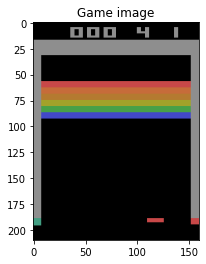

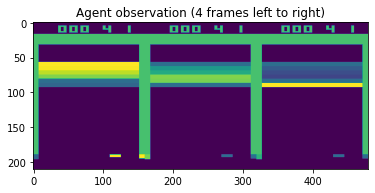

In [28]:
from tensorflow._api.v2.compat.v1 import compat
from gym.spaces import Box
from gym import ObservationWrapper, Wrapper
import gym
import random
import numpy as np
import tensorflow as tf
import cv2
from keras.layers import Conv2D, Flatten
import matplotlib.pyplot as plt

env = gym.make('BreakoutDeterministic-v4')
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

class PreprocessImage(ObservationWrapper):
    def __init__(self, env):
        ObservationWrapper.__init__(self, env)
        self.img_size = (84,84)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        img = img[34:-16, :, :]
        img - cv2.resize(img, self.img_size)
        img = img.mean(-1, keepdims=True)
        img = img.astype('float32') / 255.
        return img

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order ='tensorflow'):
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)



def Model(input_size):
    model = tf.keras.Sequential()
    ##model.add(Conv2D(32, 8, (4, 4), activation='relu', padding='valid', input_shape=(input_size, input_size, input_size), =))

In [29]:
from tensorflow.python.keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.models import Sequential

tf.compat.v1.reset_default_graph()
session = tf.compat.v1.InteractiveSession()
tf.compat.v1.disable_eager_execution()


class DQN:
    def __init__(self, name, state_shape, n_actions, epsilon=0):
        self.model = Sequential()
        self.model.add(Conv2D(32, 8, (4,4), activation='relu', padding='valid', input_shape=(state_shape)))
        self.model.add(MaxPooling2D())
        self.model.add(Conv2D(64, 4, (2,2), activation='relu', padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add(Conv2D(64, 3, (1,1), activation='relu', padding='valid'))
        self.model.add(MaxPooling2D())
        self.model.add(Flatten())
        self.model.add(Dense(256, activation="elu"))
        self.model.add(Dense(n_actions, activation='linear'))
        self.state_t = tf.compat.v1.placeholder('float32', [None,] + list(state_shape))
        self.qvalues_t = self.get_tf_qvalues(self.state_t)
        self.weights = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_tf_qvalues(self, state_t):
        qvalues = self.model(state_t)

        assert tf.compat.v1.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions

        return qvalues

    def get_qvalues(self, state_t):
        session = tf.compat.v1.get_default_session()
        return session.run(self.qvalues_t, {self.state_t: state_t})

    def sample_actions(self, qvalues):
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)


In [30]:
dqn_agent = DQN("dqn_agent", state_dim, n_actions, epsilon=0.5)
session.run(tf.compat.v1.global_variables_initializer())

In [30]:
def train(env, agent, num_games=1, greedy=False, t_max=100):
    rewards = []
    s = env.reset()
    for _ in range(num_games):
        reward = 0
        for _ in range(t_max):
            qvalues = dqn_agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
